In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import models as m
import methods as f

import preprocess as pp

import os.path as osp
import os
from PIL import Image

In [2]:
CNT_PTHS = ["/home/alma/w-projects/ccf/data/bc/bc1/bcA.h5ad",
            "/home/alma/w-projects/ccf/data/bc/bc2/bcB.h5ad"]

PROP_PTHS = ["/home/alma/w-projects/ccf/res/stereoscope/bc/2021-06-23-bc/2021-06-23-bc/iter-002/bcA/W.2021-06-24065258.298637.tsv",
             "/home/alma/w-projects/ccf/res/stereoscope/bc/2021-06-23-bc/2021-06-23-bc/iter-002/bcB/W.2021-06-24065258.298637.tsv"]

In [3]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]
props = [pd.read_csv(p,sep="\t",header = 0,index_col = 0) for p in PROP_PTHS]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
for k in range(len(adatas)):
    _tmp = props[k]
    _tmp.index  = adatas[k].obs.index
    adatas[k].obsm["stereoscope"] = _tmp
    adatas[k].obs = pd.concat((adatas[k].obs,_tmp),axis=1)

In [5]:
for a in adatas:
    print(a)

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'B-cells', 'CAFs', 'Endothelial', 'Epithelial', 'Myeloid', 'Plasmablasts', 'SMCs', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial', 'stereoscope'
AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'B-cells', 'CAFs', 'Endothelial', 'Epithelial', 'Myeloid', 'Plasmablasts', 'SMCs', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial', 'stereoscope'


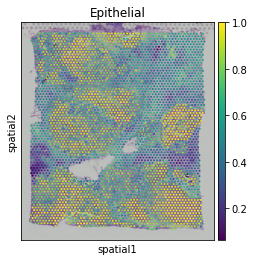

In [6]:
sc.pl.spatial(adatas[1],color = ["Epithelial"])

In [7]:
ref = m.Reference(adatas[0].obsm["spatial"],
                  landmarks = adatas[0].uns["curated_landmarks"],
                 )

/home/alma/w-projects/ccf/src/models.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = self.fwd_coordinate_transform(t.tensor(landmarks))


In [8]:
adatas = {"bcA":adatas[0],"bcB":adatas[1]}

In [9]:
for adata in adatas.values():
    sc.pp.filter_genes(adata,min_cells = 0.1)
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    
pp.match_scales(adatas["bcB"],ref)
pp.get_landmark_distance(adatas["bcB"])


/home/alma/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [55]:
ref.clean()

In [56]:
np.random.seed(1337)
cell_types = ["T-cells","Epithelial","Plasmablasts"]
idx = np.random.choice(len(adatas["bcB"]),
                       replace = False,
                       size = 1500)
losses = f.map_to_reference(dict(bcB = adatas["bcB"][idx,:]),
                            cell_types,
                            ref,
                            n_epochs=2000,
                            device ="cpu",
                            verbose = True,
                            return_losses = True,
                            return_models =False,
                            max_cg_iterations = 10000,
                           )

Processing >> Model : bcB | Feature : T-cells


100%|██████████| 2000/2000 [02:46<00:00, 11.98it/s]


Processing >> Model : bcB | Feature : Epithelial


100%|██████████| 2000/2000 [02:25<00:00, 13.73it/s]


Processing >> Model : bcB | Feature : Plasmablasts


100%|██████████| 2000/2000 [02:31<00:00, 13.22it/s]


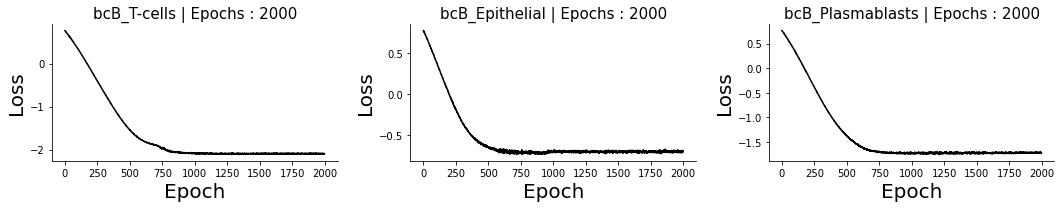

In [51]:
import utils as ut
ut.model_diagnostics(losses = losses)

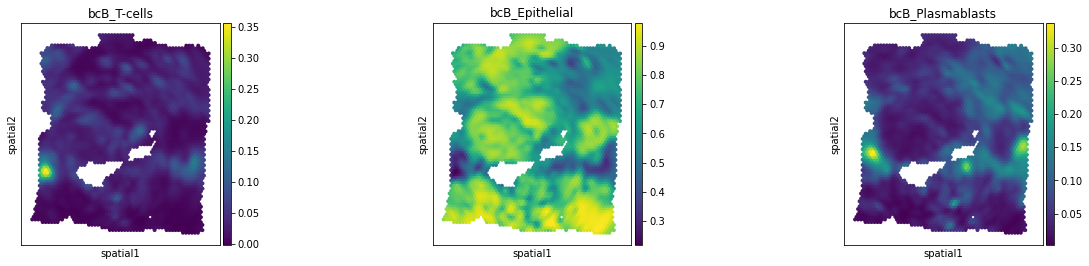

In [58]:
ref.plot(spot_size = 0.02)

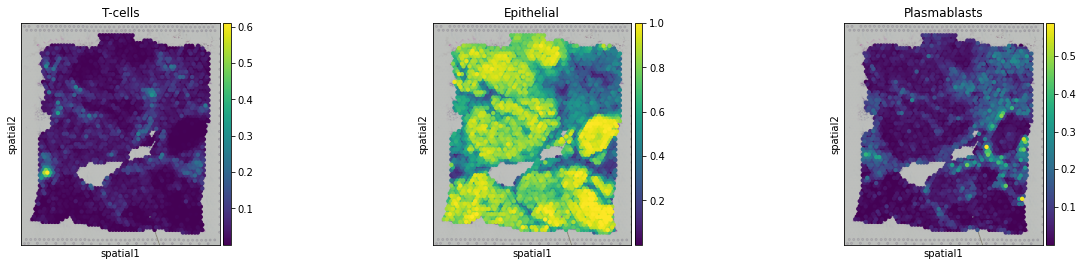

In [54]:
sc.pl.spatial(adatas["bcA"],color = ["T-cells","Epithelial","Plasmablasts"],spot_size = 400)

In [57]:
cell_types = ["T-cells","Epithelial","Plasmablasts"]

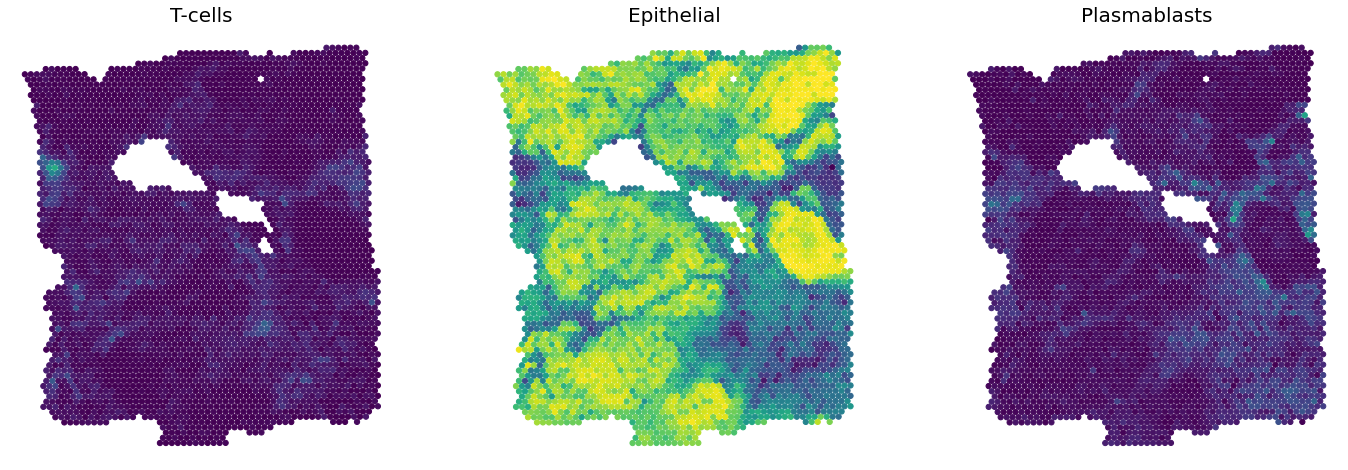

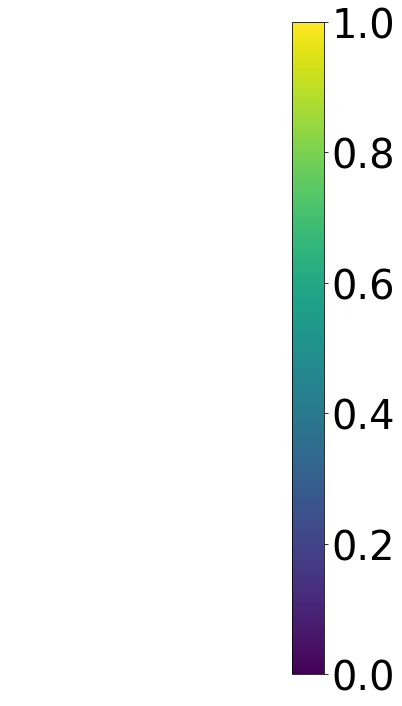

In [63]:
marker_size = 0.10
vmin = adatas["bcA"].obsm["stereoscope"][cell_types].values.min()
vmax = adatas["bcA"].obsm["stereoscope"][cell_types].values.max()
fig,ax = plt.subplots(1,3,figsize = (24,8))
ax = ax.flatten()

for k,ct in enumerate(cell_types):
    crd = adatas["bcA"].obsm["spatial"]
    delta = cdist(crd,crd)
    delta[delta == 0] = np.inf
    delta = np.min(delta,axis=1)
    _sc = ax[k].scatter(crd[:,0],
                        crd[:,1],
                        c = adatas["bcA"].obsm["stereoscope"][ct].values,
                        vmin = vmin,
                        vmax = vmax,
                        cmap = plt.cm.viridis,
                        s = marker_size* delta,
                       )
    ax[k].set_aspect("equal")
    ax[k].axis("off")
    ax[k].set_title(ct,fontsize = 20)
    
plt.show()
fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=40)
plt.show()

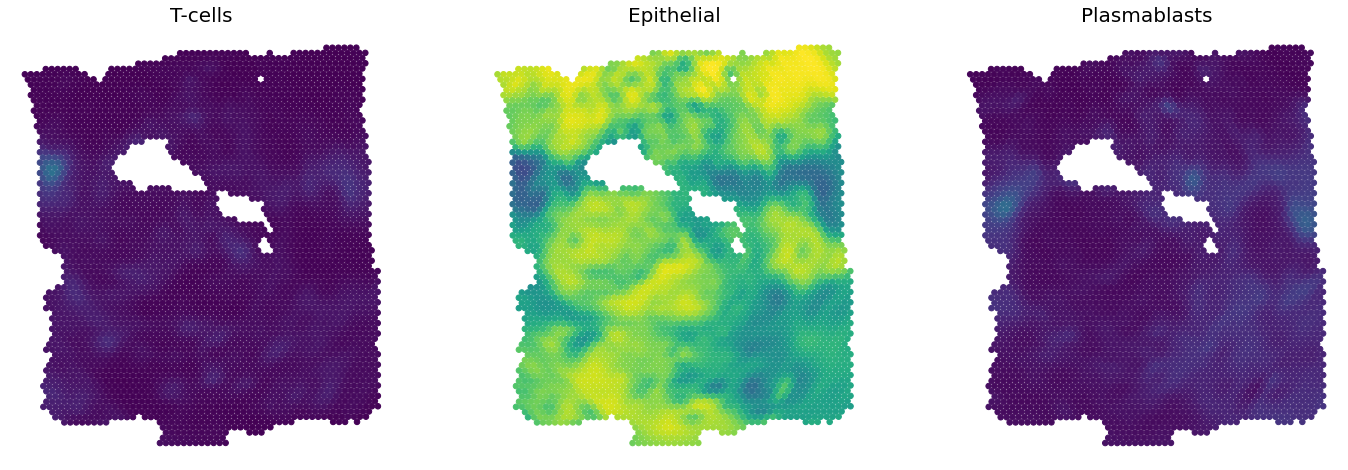

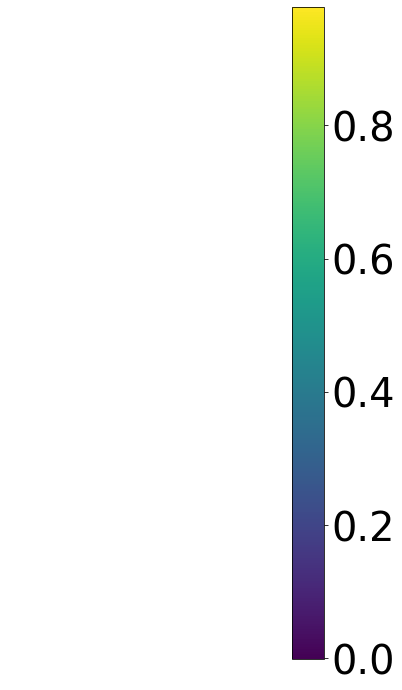

In [71]:
marker_size = 2000
vmin = ref.adata.X.min()
vmax = ref.adata.X.max()
fig,ax = plt.subplots(1,3,figsize = (24,8))
ax = ax.flatten()

for k,ct in enumerate(cell_types):
    crd = ref.domain.numpy()
    delta = cdist(crd,crd)
    delta[delta == 0] = np.inf
    delta = np.min(delta,axis=1)
    _sc = ax[k].scatter(crd[:,0],
                        crd[:,1],
                        c = ref.adata.X[:,k],
                        vmin = vmin,
                        vmax = vmax,
                        cmap = plt.cm.viridis,
                        s = marker_size* delta,
                       )
    ax[k].set_aspect("equal")
    ax[k].axis("off")
    ax[k].set_title(ct,fontsize = 20)
    
plt.show()
fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=40)
plt.show()